In [ ]:
pip install pandas requests vaderSentiment yake rapidfuzz gensim numpy scikit-learn openpyxl

In [ ]:
import requests
import os
import csv

# Reddit JSON endpoint (Replace with any Reddit post URL)
url = "https://www.reddit.com/r/Corsair/comments/vrxdlv/corsair_products_opinions.json"
headers = {"User-Agent": "Mozilla/5.0"}

# Fetch data
response = requests.get(url, headers=headers)

# Function to recursively extract comments and replies
def extract_comments(comment_data, comments_list):
    if isinstance(comment_data, dict) and "body" in comment_data:
        comment_body = comment_data.get("body", "N/A")
        author = comment_data.get("author", "N/A")
        
        if comment_body != "N/A":  # Exclude empty or removed comments
            comments_list.append({"username": author, "comment": comment_body})

    # Check for replies
    if "replies" in comment_data and comment_data["replies"] != "":
        replies = comment_data["replies"]["data"]["children"]
        for reply in replies:
            extract_comments(reply["data"], comments_list)

if response.status_code == 200:
    data = response.json()

    
    comments_data = []

    
    if isinstance(data, list) and len(data) > 1:
     
        post_data = data[0]["data"]["children"][0]["data"]
        post_author = post_data.get("author", "N/A")
        post_body = post_data.get("selftext", "N/A") 

        
        if post_body != "N/A":  
            comments_data.append({"username": post_author, "comment": post_body})

        
        comments_list = data[1].get("data", {}).get("children", [])
        
        if not comments_list:
            print("No comments found in this post.")
        else:
            for comment in comments_list:
                if isinstance(comment, dict) and "data" in comment:
                    extract_comments(comment["data"], comments_data)

    else:
        print("Unexpected JSON structure.")

    
    if comments_data:
    
        downloads_path_csv = os.path.join(os.path.expanduser("~"), "Downloads", "reddit_comments8.csv")

        
        with open(downloads_path_csv, "w", newline="", encoding="utf-8") as csvfile:
            fieldnames = ["username", "comment"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for comment in comments_data:
                writer.writerow(comment)

        print(f"Reddit comments saved to CSV: {downloads_path_csv}")

    else:
        print("No comments to save.")

else:
    print(f"Error: {response.status_code}")

Reddit comments saved to CSV: C:\Users\prati\Downloads\reddit_comments8.csv


✅ Analyzed data saved to C:\Users\prati\Downloads\reddit_comments_analysis.csv


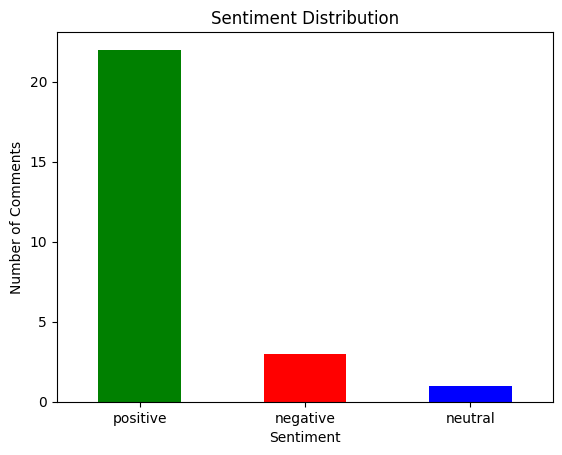

In [43]:
import pandas as pd
import os
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from yake import KeywordExtractor
from rapidfuzz import fuzz
import gensim.downloader as api
import matplotlib.pyplot as plt

word2vec_model = api.load("glove-wiki-gigaword-50")

# List of Products (Replace with your actual product list)
products = [
    "Memory Dominator Platinum RGB",
    "iCUE Software",
    "Memory Vengeance LPX",
    "Memory Vengeance RGB Pro",
    "Memory Vengeance LPX DDR5",
    "PSUs RMx Series",
    "PSUs HX Series",
    "PSUs CV Series",
    "PSUs AX Series",
    "PSUs RM Series",
    "Keyboards K95 RGB Platinum",
    "Keyboards K100 RGB",
    "Keyboards K70 RGB",
    "Keyboards K60 RGB Pro",
    "Keyboards K65 RGB MINI",
    "iCUE TITAN 360 RX RGB",
    "iCUE H170i",
    "iCUE H100i",
    "iCUE H150i RGB ELITE Liquid CPU Cooler",
    "Fans iCUE QL RGB",
    "Fans LL RGB",
    "Fans AF Series",
    "Fans SP RGB Elite",
    "Fans ML Series",
    "Headsets VOID RGB Elite",
    "Headsets HS60 Pro",
    "Headsets Virtuoso RGB Wireless",
    "Headsets HS70 Pro",
    "Headsets 700 Series",
    "MP600 Gen 4",
    "Force Series MP510",
    "USB Flash Drives",
    "MP400 SSD",
    "MP600 Pro XT",
    "Mousepad MM300",
    "Mousepad MM350 Pro",
    "Mousepad MM700 RGB",
    "Mousepad MM1000 Qi Wireless Charging",
    "Mousepad MM350",
    "Monitor XENEON FLEX",
    "Monitor 27QHD240",
    "Monitor 34WQHD240"
]

# Product Categories for Inference
product_categories = {
    "Memory": ["memory", "ram", "dominator", "vengeance", "WS DDRS"],
    "PSUs": ["psu", "power supply", "RMAs","RM1000x", "RM650", "HX1000i", "SF850", "RM750x"],
    "Keyboards": ["keyboard", "k95", "k70", "k60", "k65","K100","K55"],
    "Coolers": ["cooler", "h170i", "h100i", "h150i", "Titan 360 RX RGB"],
    "Fans": ["fan", "iCUE QX120 RGB", "iCUE QX140 RGB", "iCUE LX120 RGB", "RS140mm", "RS120mm ARG", "P12 ARGBs"],
    "Headsets": ["headset", "void", "hs60", "virtuoso", "hs70", "700 series"],
    "Storage": ["mp600", "mp510", "mp400", "ssd", "flash drive"],
    "Cases": ["2500X", "6500D", "3500X ARGB", "480T", "3000D"],
    "Monitor": ["XENEON", "27QHD240", "34WQHD240","LG 34GK950GF","LCD"],
    "Mouse" : ["M65", "Mice","M75", "M55","Harpoon"],
    "Mousepads": ["mousepad", "mm300", "mm350", "mm700", "mm1000","MM500"]
}

# Gaming Hardware-Specific Issue Categories
issue_categories = {
    "hardware failure": ["overheating", "fan noise", "power failure", "not turning on", "faulty", "broken", "defective", "bricked", "leaking", "double clicking", "scroll wheel issue", "dead LEDs", "battery swelling"],
    "performance issues": ["lag", "fps drop", "frame rate", "stuttering", "slow", "freezing", "throttling", "unresponsive", "input delay", "phantom clicks"],
    "connectivity issues": ["bluetooth", "Wi-Fi", "connection lost", "disconnecting", "controller not syncing", "USB receiver", "dongle", "pairing", "wireless", "signal drop"],
    "software/driver issues": ["driver", "firmware", "update error", "not detecting", "incompatible", "crash", "iCue", "software bug", "profile loss", "RGB control", "firmware brick"],
    "warranty/returns": ["warranty", "refund", "replacement", "RMA", "customer support", "service center", "shipping costs", "destruction proof", "refund policy", "warranty claim", "replacement denied"],
    "battery issues": ["battery life", "degradation", "not charging", "swelling", "short battery life", "battery memory", "charging issues", "battery replacement"],
    "audio issues": ["crackling sound", "microphone echo", "sound quality", "audio dropouts", "mic not working", "audio distortion", "headset audio"],
    "RGB/LED issues": ["LED burnout", "RGB not working", "stuck LEDs", "color issues", "LED failure", "RGB software", "lighting control"],
    "build quality": ["cheap materials", "poor construction", "plastic wear", "hinge breakage", "keycap wear", "coating peeling", "durability", "material degradation"],
    "customer service": ["slow response", "unhelpful", "RMA process", "ticket system", "support quality", "communication issues", "refusal to replace", "warranty denial"],
    "shipping/delivery issues": ["delayed shipping", "damaged delivery", "lost package", "shipping costs", "international shipping", "customs fees", "delivery issues"],
    "compatibility issues": ["incompatible", "driver conflict", "software conflict", "hardware conflict", "USB port issues", "motherboard compatibility", "OS compatibility"]
}

def analyze_sentiment(df):
    analyzer = SentimentIntensityAnalyzer()
    df["Sentiment"] = df["comment"].apply(lambda x: 'positive' if analyzer.polarity_scores(x)["compound"] >= 0.05 else 
                                          ('negative' if analyzer.polarity_scores(x)["compound"] <= -0.05 else 'neutral'))
    return df

def extract_keywords(df):
    kw_extractor = KeywordExtractor()
    df["Keywords"] = df["comment"].apply(lambda x: [kw[0] for kw in kw_extractor.extract_keywords(x)] if x else [])
    return df


def get_similar_issue(comment):
    comment_lower = comment.lower()
    max_score = 0
    detected_issue = "general complaint"

    for issue, keywords in issue_categories.items():
        for keyword in keywords:
            fuzz_score = fuzz.partial_ratio(comment_lower, keyword)
            word_vector_similarity = 0  

            if keyword in word2vec_model.key_to_index:
                words = comment_lower.split()
                valid_words = [w for w in words if w in word2vec_model.key_to_index]

                if valid_words:
                    word_vector_similarity = max(word2vec_model.similarity(keyword, w) for w in valid_words)

            combined_score = max(fuzz_score, word_vector_similarity * 100)

            if combined_score > max_score:
                max_score = combined_score
                detected_issue = issue

    return detected_issue

def identify_issues(df):
    df["Issue"] = df.apply(lambda row: get_similar_issue(row["comment"]) if row["Sentiment"] == "negative" else "N/A", axis=1)
    return df


def identify_product(comment):
    comment_lower = comment.lower()
    detected_products = set()
    

    for product in products:

        product_pattern = re.compile(rf"\b{re.escape(product.lower())}\b", re.IGNORECASE)
        if product_pattern.search(comment_lower):
            detected_products.add(product)
    

    for category, keywords in product_categories.items():
        for keyword in keywords:
            if keyword.lower() in comment_lower:
                detected_products.add(f"{category} ({keyword})") 
    
 
    if "icue" in comment_lower:
        detected_products.add("iCUE Software")
    
    return ", ".join(detected_products) if detected_products else "N/A"

def identify_products(df):
    df["Product"] = df["comment"].apply(identify_product)
    return df


def main():
    csv_path = os.path.join(os.path.expanduser("~"), "Downloads", "reddit_comments8.csv")
    df = pd.read_csv(csv_path)

    # Perform sentiment analysis
    df = analyze_sentiment(df)

    df = extract_keywords(df)

    df = identify_issues(df)

    df = identify_products(df)

    output_csv_path = os.path.join(os.path.expanduser("~"), "Downloads", "reddit_comments_analysis.csv")
    df.to_csv(output_csv_path, index=False, encoding='utf-8')

    print(f"✅ Analyzed data saved to {output_csv_path}")

    # Plot sentiment distribution
    sentiment_counts = df["Sentiment"].value_counts()
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Comments")
    plt.xticks(rotation=0)
    plt.show()

if __name__ == "__main__":
    main()